# <center><b> Dictionary Learning</b></center>

## Librerías

In [116]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
import pingouin as pg
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import DictionaryLearning

warnings.filterwarnings("ignore")

## Funciones

In [54]:
def plot_hist(df, variables, bins=50, n_cols=3, figsize=(16,10)):
    n_vars = len(variables)
    n_rows = int(np.ceil(n_vars / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, var in enumerate(variables):
        ax = axes[i]
        data = df[var].dropna()
        n, bins_edges, patches = ax.hist(
            data, bins=bins, facecolor='#2ab0ff', 
            edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
        n = n.astype(int)
        for j in range(len(patches)):
            patches[j].set_facecolor(plt.cm.viridis(n[j]/max(n)))
        mean_val = data.mean()
        median_val = data.median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f"Media: {mean_val:.2f}")
        ax.axvline(median_val, color='green', linestyle='-', linewidth=1.5, label=f"Mediana: {median_val:.2f}")
        ax.set_title(var, fontsize=12)
        ax.set_xlabel("Valor", fontsize=10)
        ax.set_ylabel("Frecuencia", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(1.2)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def detect_outliers_summary(data, n_cols=3, threshold=3, figsize=(15, 10)):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    results = []
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        mean = data[col].mean()
        std = data[col].std()
        z_scores = (data[col] - mean) / std
        outliers_z = data[np.abs(z_scores) > threshold]
        results.append({
            "Variable": col,
            "Outliers_IQR": len(outliers_iqr),
            "Outliers_ZScore": len(outliers_z)
        })
    outlier_summary = pd.DataFrame(results)
    n_vars = len(numeric_cols)
    n_rows = int(np.ceil(n_vars / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=data[col], color="skyblue", ax=axes[i])
        axes[i].set_title(f"Boxplot de {col}")
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()
    return outlier_summary

## Datos

In [121]:
# boston = fetch_openml(name="boston", version=1, as_frame=True)
# df, y = boston.data, boston.target
digits = load_digits()
df = pd.DataFrame(digits.data, columns=[f"pixel_{i}" for i in range(digits.data.shape[1])])
# df = df.drop(['RAD','CHAS'],axis=1)
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_54,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


## Análisis Exploratorio de Datos

### Dimensiones

In [122]:
df.shape

(1797, 64)

### Tipos de Datos

In [123]:
df.dtypes

pixel_0     float64
pixel_1     float64
pixel_2     float64
pixel_3     float64
pixel_4     float64
             ...   
pixel_59    float64
pixel_60    float64
pixel_61    float64
pixel_62    float64
pixel_63    float64
Length: 64, dtype: object

### Valores Nulos

In [124]:
df.isna().sum()

pixel_0     0
pixel_1     0
pixel_2     0
pixel_3     0
pixel_4     0
           ..
pixel_59    0
pixel_60    0
pixel_61    0
pixel_62    0
pixel_63    0
Length: 64, dtype: int64

### Descriptivos

In [125]:
df.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_54,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [126]:
pd.DataFrame((df.describe().loc['std',]/np.abs(df.describe().loc['mean',])*100), columns = ['CV']).sort_values('CV', ascending=False).T

,pixel_56,pixel_24,pixel_48,pixel_16,pixel_31,pixel_8,pixel_40,pixel_47,pixel_23,pixel_7,...,pixel_10,pixel_12,pixel_60,pixel_59,pixel_4,pixel_3,pixel_11,pixel_0,pixel_32,pixel_39
CV,4239.103679,2996.664348,2822.992533,2241.516449,2117.780873,1693.16134,1630.613844,1127.180673,875.73298,800.075963,...,52.218233,46.527052,41.780799,36.187282,36.186352,35.898109,33.203159,NaN,NaN,NaN


### Visualización

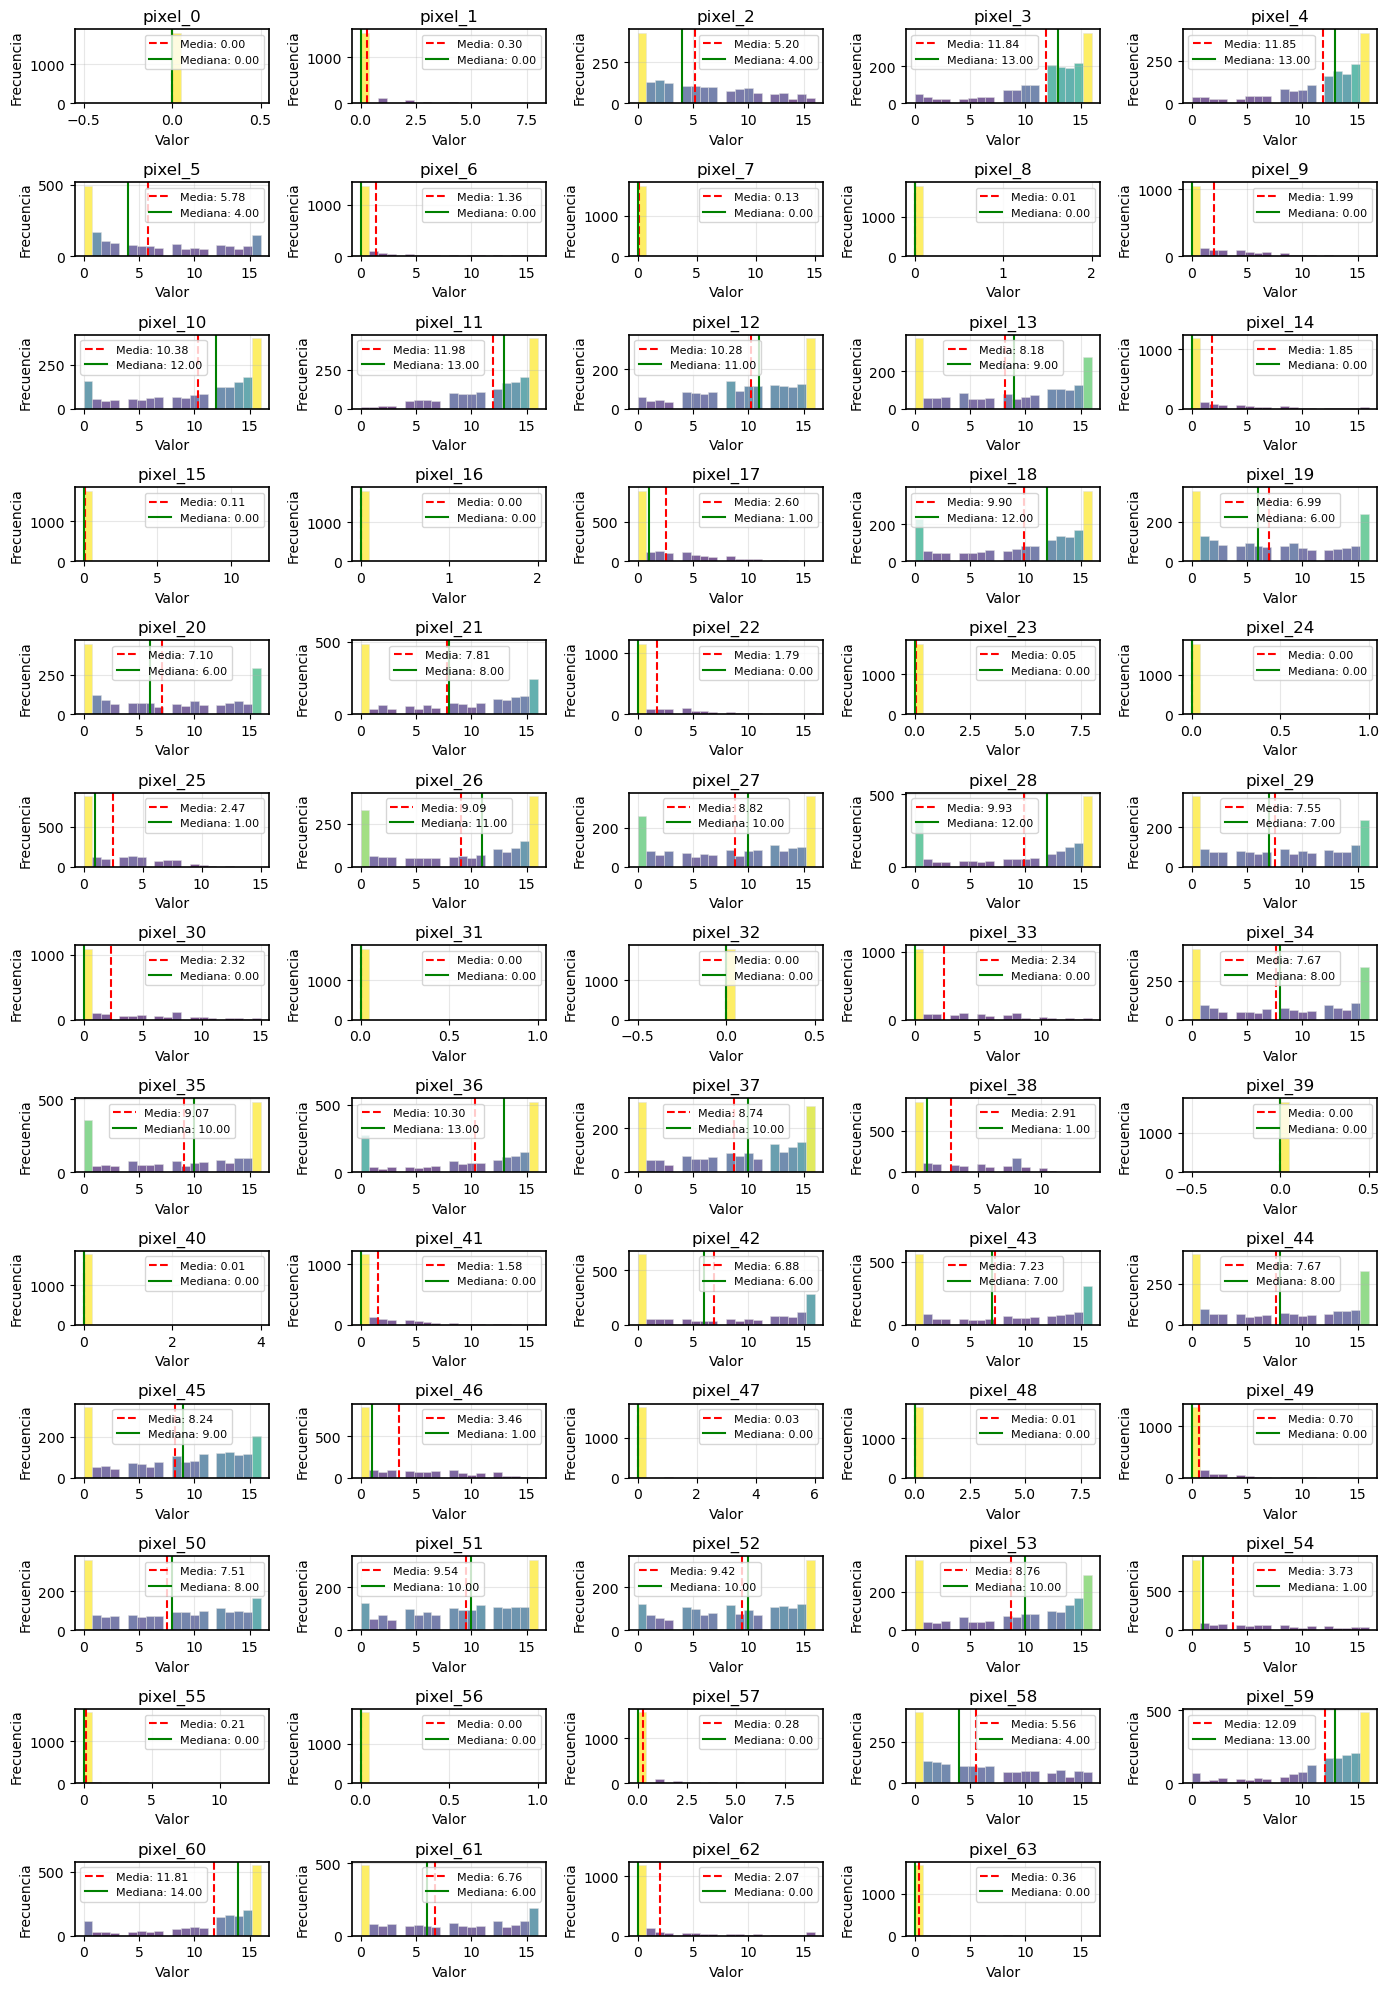

In [128]:
plot_hist(df, df.columns, bins=20, n_cols=5, figsize=(14,20))

### Correlaciones

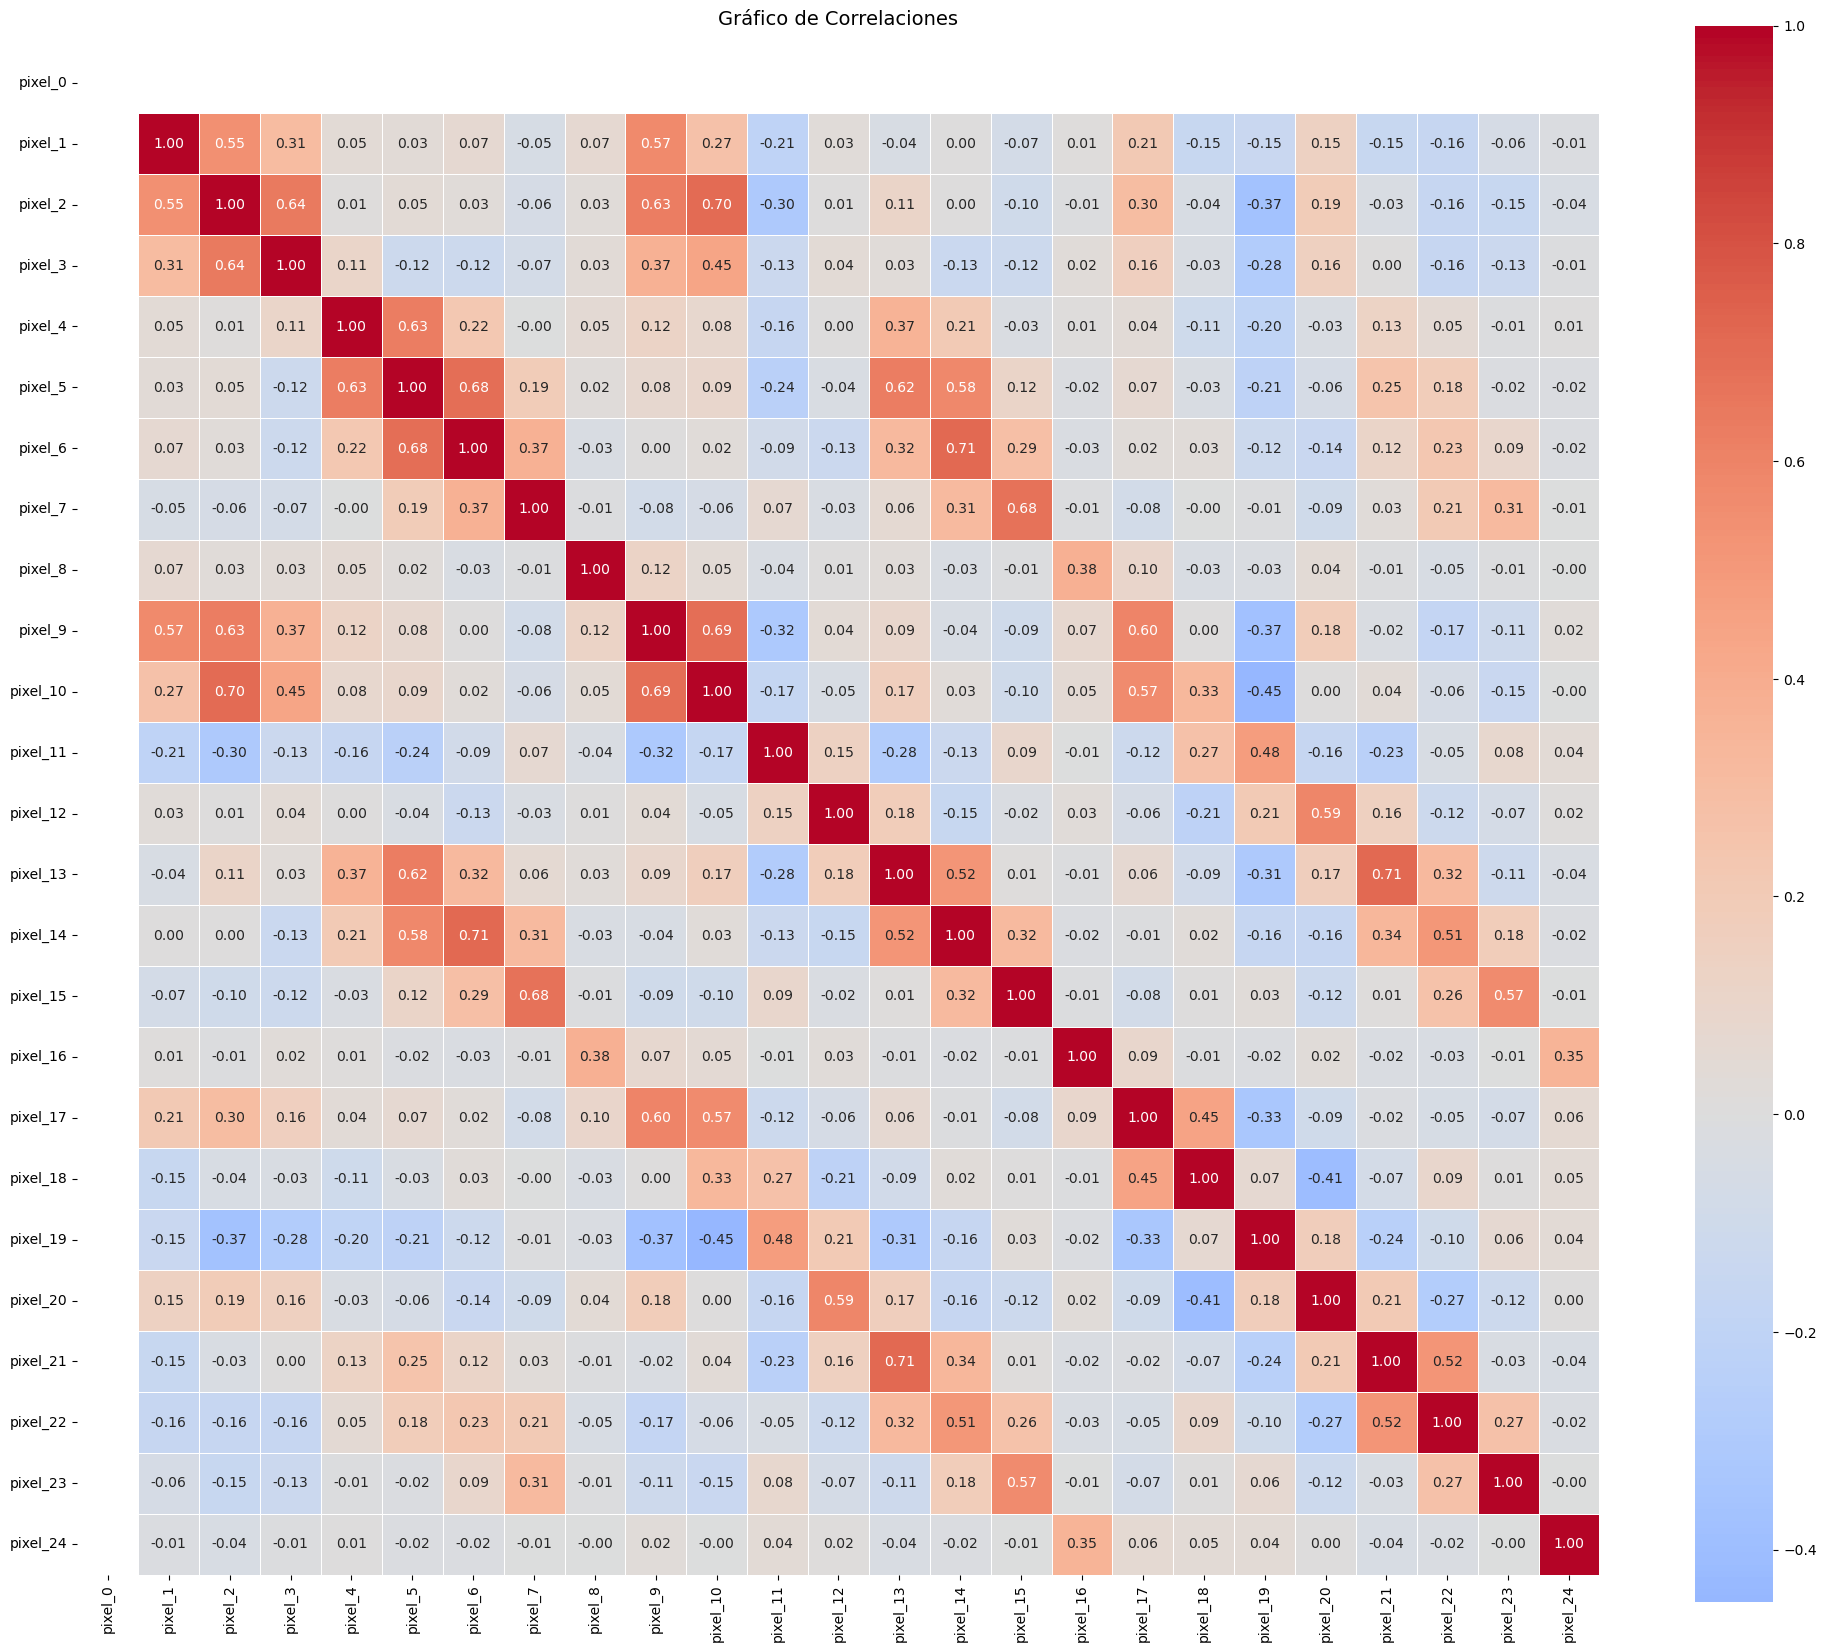

In [158]:
corr_matrix = df.iloc[:,:25].corr(method='spearman')
plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_matrix, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0, 
    square=True,
    linewidths=.5, 
    cbar_kws={"shrink": .8}
)
plt.title("Gráfico de Correlaciones", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Outliers

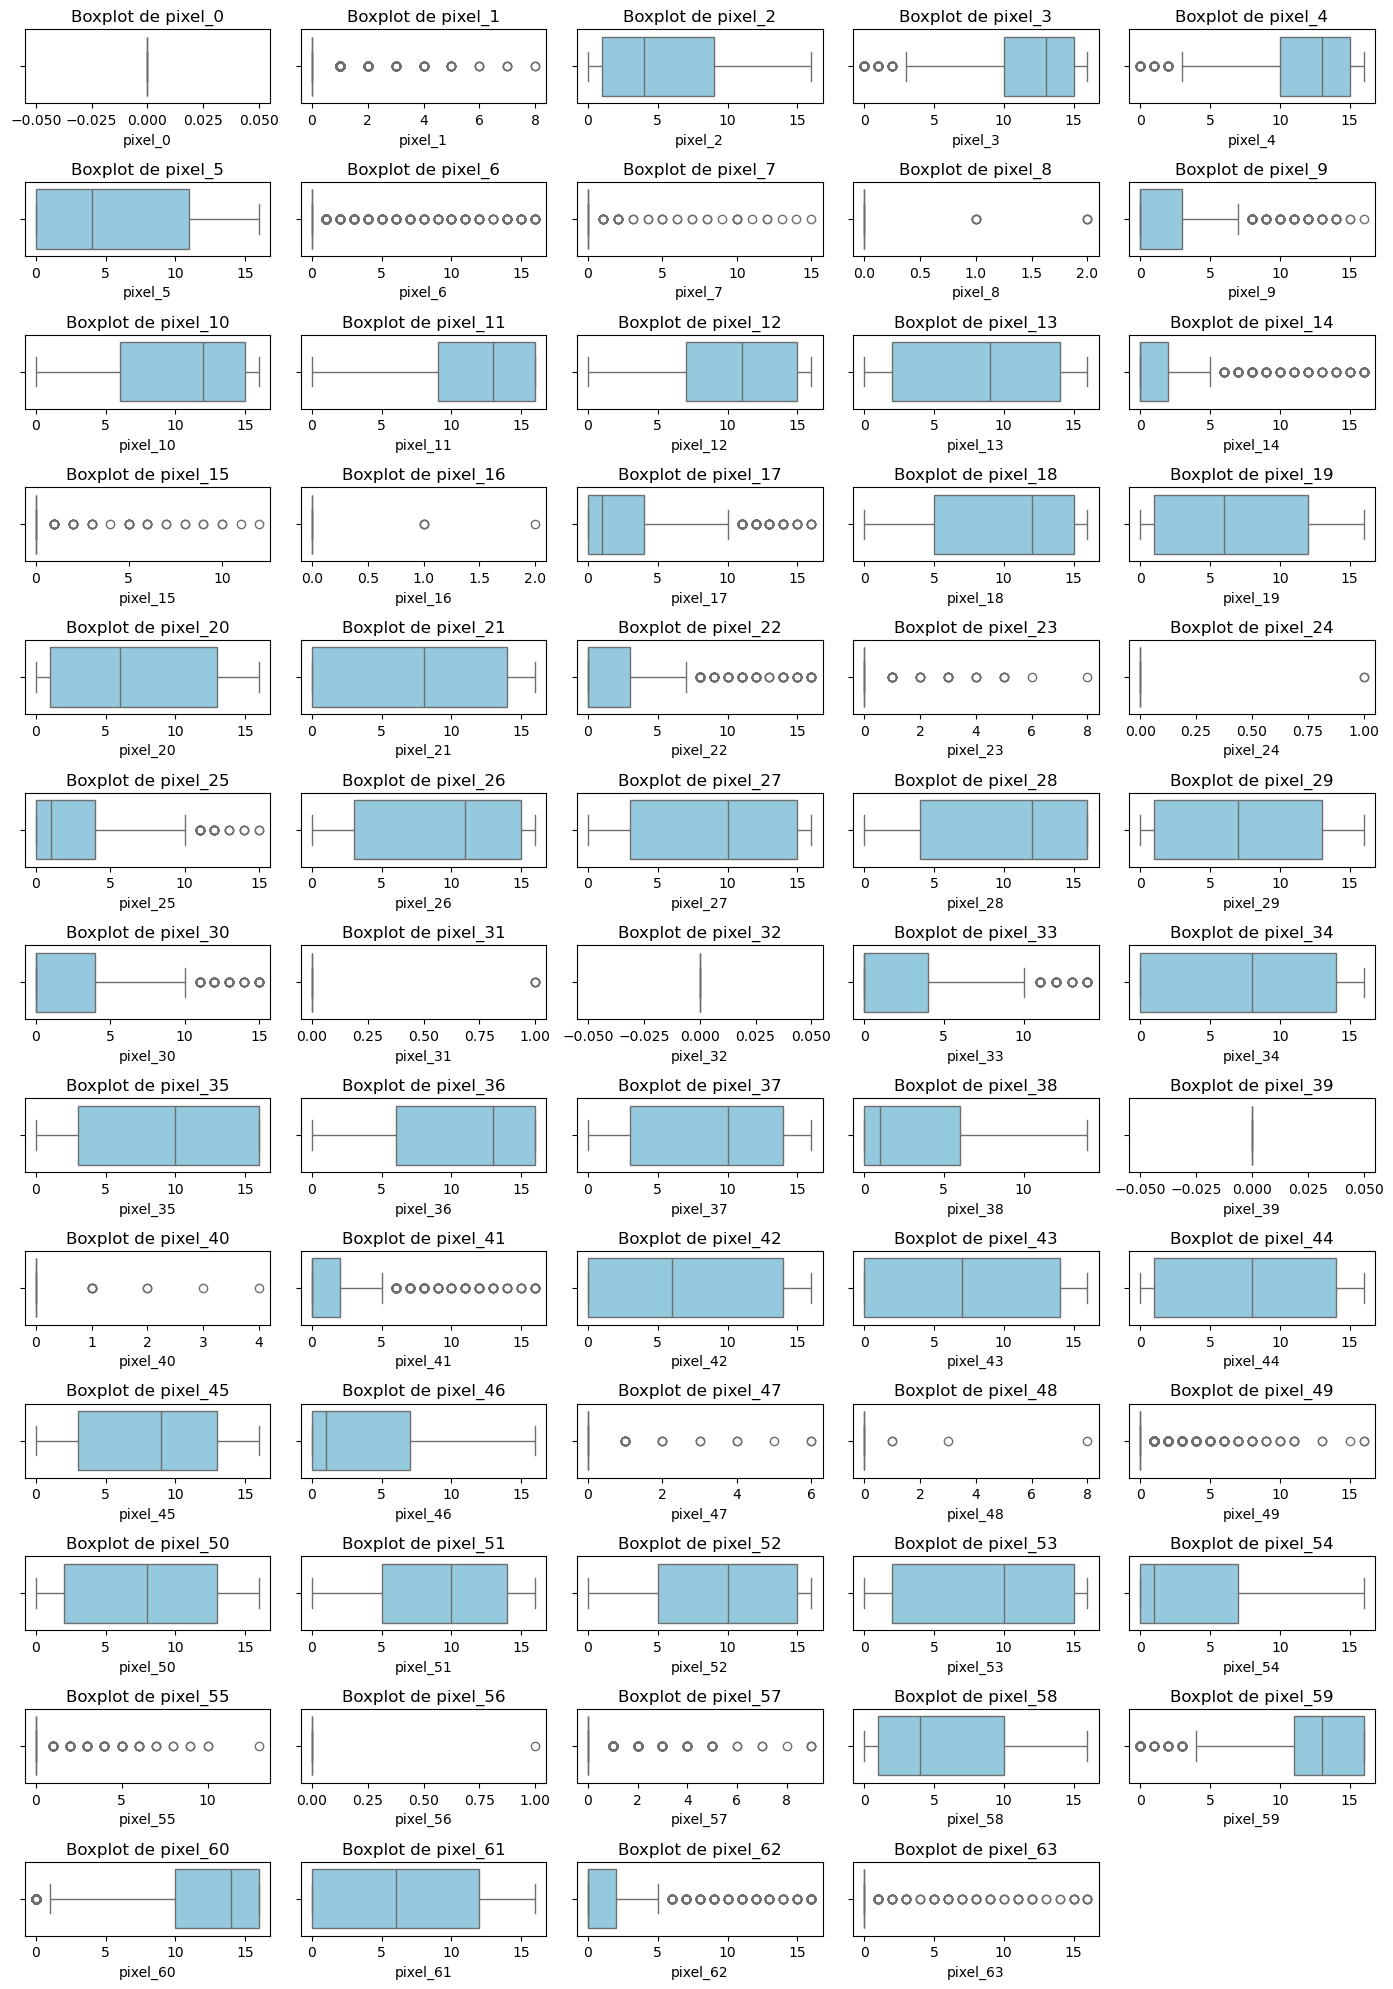

,Variable,Outliers_IQR,Outliers_ZScore
0,pixel_0,0,0
1,pixel_1,266,39
2,pixel_2,0,0
3,pixel_3,112,0
4,pixel_4,100,0
...,...,...,...
59,pixel_59,144,0
60,pixel_60,114,0
61,pixel_61,0,0
62,pixel_62,267,69


In [131]:
detect_outliers_summary(df, n_cols=5, threshold=3, figsize=(14,20))

## Preprocesamiento de Datos

### Separación de Datos

In [132]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

### Escalado de Variables

In [133]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelamiento

### Número de componentes

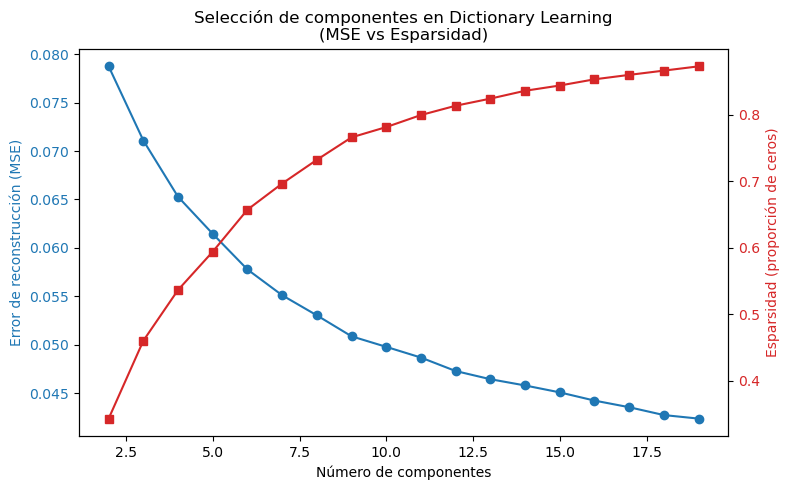

In [134]:
errors = []
sparsities = []
components_range = range(2, 20)
for k in components_range:
    dl = DictionaryLearning(n_components=k, random_state=42)
    X_dl = dl.fit_transform(X_train_scaled)
    X_rec = np.dot(X_dl, dl.components_)
    errors.append(mean_squared_error(X_train_scaled, X_rec))
    sparsity = np.mean(X_dl == 0)
    sparsities.append(sparsity)

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(components_range, errors, marker="o", color="tab:blue", label="Error (MSE)")
ax1.set_xlabel("Número de componentes")
ax1.set_ylabel("Error de reconstrucción (MSE)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.plot(components_range, sparsities, marker="s", color="tab:red", label="Esparsidad")
ax2.set_ylabel("Esparsidad (proporción de ceros)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
plt.title("Selección de componentes en Dictionary Learning\n(MSE vs Esparsidad)")
fig.tight_layout()
plt.show()

### Ejecución del Modelo

In [144]:
dict_learn = DictionaryLearning(n_components=8, random_state=42)
X_train_dl = dict_learn.fit_transform(X_train_scaled)
X_test_dl = dict_learn.transform(X_test_scaled)
D = dict_learn.components_   
X_reconstructed = np.dot(X_train_dl, D)

### Supuestos del modelo

#### Linealidad de la representación

In [145]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(X_train_scaled, X_reconstructed)
print("Error cuadrático medio (MSE):", mse)

Error cuadrático medio (MSE): 0.05303630047239083


#### Dispersidad (sparsity)

In [146]:
sparsity = np.mean(np.isclose(X_train_dl, 0))
print("Proporción de coeficientes cero (esparsidad):", sparsity)

Proporción de coeficientes cero (esparsidad): 0.7322546972860126


## Visualización

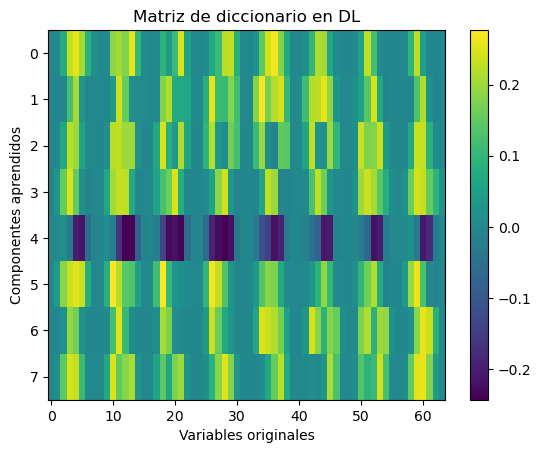

In [147]:
plt.imshow(D, aspect="auto", cmap="viridis")
plt.colorbar()
plt.xlabel("Variables originales")
plt.ylabel("Componentes aprendidos")
plt.title("Matriz de diccionario en DL")
plt.show()

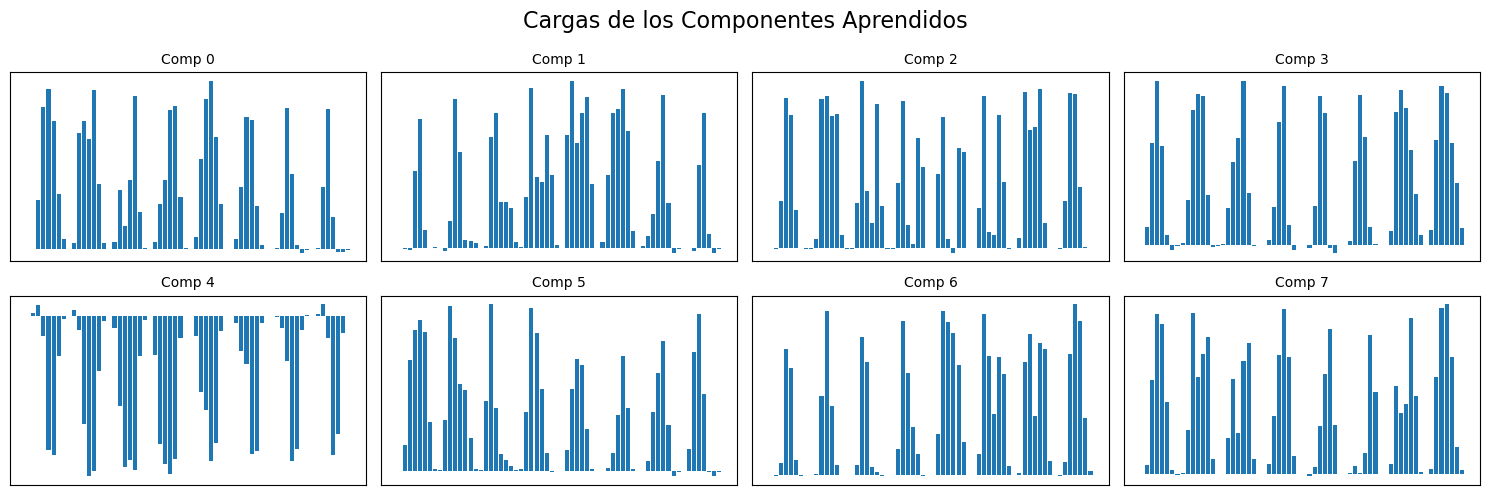

In [151]:
n_componentes = 8 
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.flatten()
for i in range(n_componentes):
    axes[i].bar(np.arange(D.shape[1]), D[i])
    axes[i].set_title(f"Comp {i}", fontsize=10)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.suptitle("Cargas de los Componentes Aprendidos", fontsize=16)
plt.tight_layout()
plt.show()

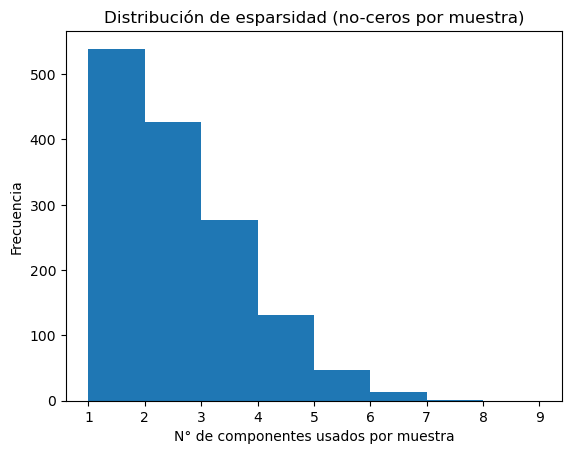

In [152]:
nonzero_counts = (X_train_dl != 0).sum(axis=1)
plt.hist(nonzero_counts, bins=range(1, X_train_dl.shape[1] + 2))
plt.xlabel("N° de componentes usados por muestra")
plt.ylabel("Frecuencia")
plt.title("Distribución de esparsidad (no-ceros por muestra)")
plt.show()

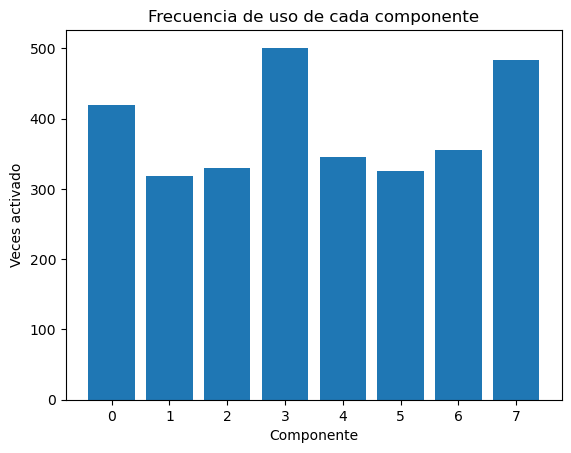

In [153]:
activation_freq = (X_train_dl != 0).sum(axis=0)
plt.bar(np.arange(len(activation_freq)), activation_freq)
plt.xlabel("Componente")
plt.ylabel("Veces activado")
plt.title("Frecuencia de uso de cada componente")
plt.show()

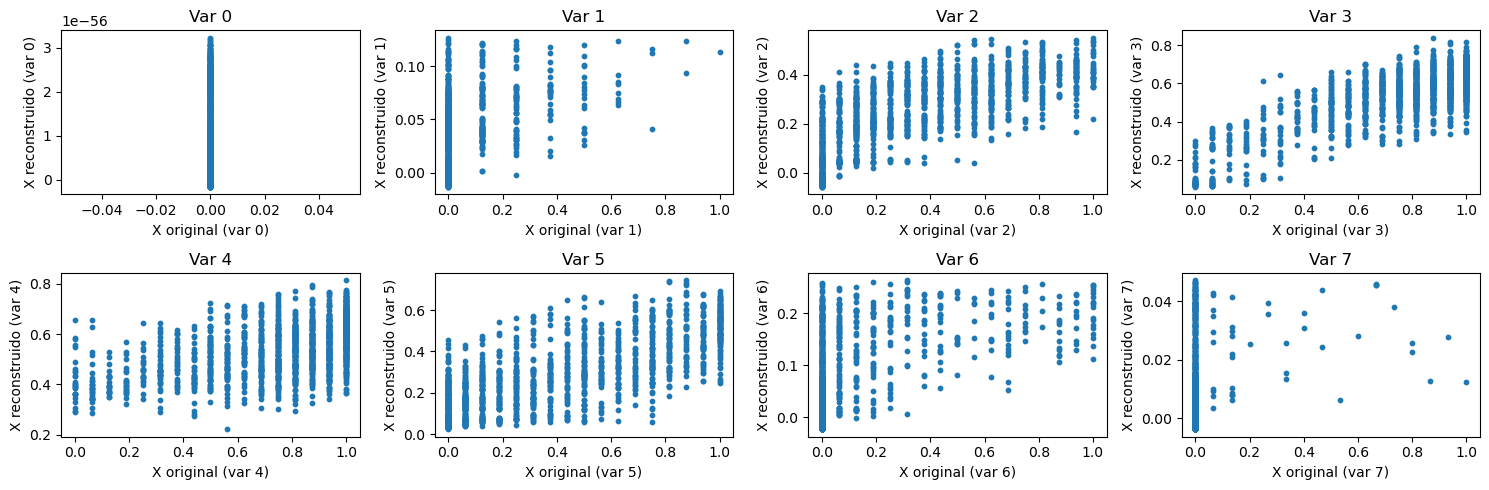

In [156]:
n_vars = min(8, X_train_scaled.shape[1])
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.ravel()
for j in range(n_vars):
    axes[j].scatter(X_train_scaled[:, j], X_reconstructed[:, j], s=10)
    axes[j].set_xlabel(f"X original (var {j})")
    axes[j].set_ylabel(f"X reconstruido (var {j})")
    axes[j].set_title(f"Var {j}")
for k in range(n_vars, len(axes)):
    axes[k].axis("off")
plt.tight_layout()
plt.show()

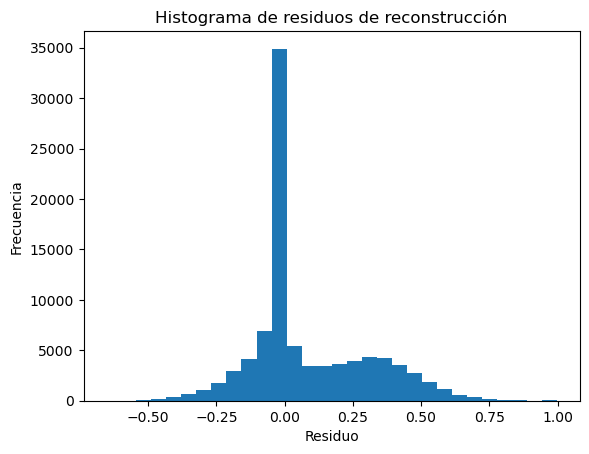

In [157]:
residuals = X_train_scaled - X_reconstructed
plt.hist(residuals.ravel(), bins=30)
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos de reconstrucción")
plt.show()